Make sure the tf version is 2.5.0-dev20201111 or later (for model saving)

In [1]:
#!pip install tf-nightly -qqq --progress-bar off
import tensorflow as tf
print(tf.__version__)
#assert tf.__version__== '2.5.0-dev20201111','bad version'

2.5.0-dev20201123


In [2]:
tf.test.gpu_device_name()

''

In [3]:
# %tensorflow_version 2.x
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [4]:
!nvidia-smi -L

/bin/sh: nvidia-smi: command not found


In [5]:
from datetime import datetime;now = datetime.now;t00 = now()
print(t00)

2020-12-07 21:14:56.233599


In [6]:
# %tensorflow_version 2.x
# import tensorflow as tf
# import timeit

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   print(
#       '\n\nThis error most likely means that this notebook is not '
#       'configured to use a GPU.  Change this in Notebook Settings via the '
#       'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
#   raise SystemError('GPU device not found')

# def cpu():
#   with tf.device('/cpu:0'):
#     random_image_cpu = tf.random.normal((100, 100, 100, 3))
#     net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
#     return tf.math.reduce_sum(net_cpu)

# def gpu():
#   with tf.device('/device:GPU:0'):
#     random_image_gpu = tf.random.normal((100, 100, 100, 3))
#     net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
#     return tf.math.reduce_sum(net_gpu)
  
# # We run each op once to warm up; see: https://stackoverflow.com/a/45067900
# cpu()
# gpu()

# # Run the op several times.
# print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
#       '(batch x height x width x channel). Sum of ten runs.')
# print('CPU (s):')
# cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
# print(cpu_time)
# print('GPU (s):')
# gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
# print(gpu_time)
# print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

In [7]:
# from google.colab import drive
# drive.mount("/content/drive")
# print('done, mounted')

In [8]:
# cd '/content/drive/My Drive/BC-MRI-AE/Colab Notebooks'

In [9]:
%matplotlib inline

import os
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from tqdm import tqdm

#from contrastive_vae.celeb_utils import get_celeb_vae
#from contrastive_vae.celeb_utils import get_celeb_cvae

import pandas as pd
from sklearn.metrics import silhouette_score

from mri_utils import get_MRI_CVAE_3D,get_MRI_CCVAE_3D

print(now()-t00)

0:00:00.439166


In [10]:
cd ../

/Users/aidasaglinskas/Desktop/BC-MRI-AE


SHAPE THE DATA

In [11]:
arr = np.load('./Data/ABIDE-Anat-64iso.npz')
ABIDE_data = arr['data']
ABIDE_subs = arr['subs']
nsubs = ABIDE_data.shape[0]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

[(1022,), (1022, 64, 64, 64)]

In [12]:
aa = np.array([ABIDE_data[s,:,:,:].sum() for s in range(ABIDE_data.shape[0])])<5000
ABIDE_data = ABIDE_data[~aa,:,:,:]
ABIDE_subs = ABIDE_subs[~aa]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

[(982,), (982, 64, 64, 64)]

In [13]:
df = pd.read_csv('./CSVs/ABIDE-legend.csv',header=0)
df = df.iloc[np.array([df['BIDS_ID'].values[s] in ABIDE_subs for s in range(len(df))])]
df.reset_index(inplace=True)

assert len(df)==len(ABIDE_subs),'dif lenghts'
assert all([df['BIDS_ID'][s]==ABIDE_subs[s] for s in range(len(df))]),'mismatch between df and goodsubs'

df.head(5)

,index,BIDS_ID,Anonymized ID,Subject Type,Visit,Days since enrollment,SubID,DxGroup,DSMIVTR,AgeAtScan,...,WISC4 Pic Con Scaled,WISC4 Matrix Scaled,WISC4 Dig Span Scaled,WISC4 Let Num Scaled,WISC4 Coding Scaled,WISC4 Sym Scaled,Age at MPRAGE,Current Med Status,Medication Name,Off stimulants at EPI scan?
0,0,sub-001,A00033348,PATIENT,session_1,8,51320,1,2,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
1,1,sub-002,A00033398,CONTROL,session_1,8,51373,2,0,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2,2,sub-003,A00033352,PATIENT,session_1,8,51324,1,2,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
3,3,sub-004,A00033389,CONTROL,session_1,8,51364,2,0,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
4,4,sub-005,A00033354,PATIENT,session_1,8,51326,1,2,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


In [14]:
TD_subs = ABIDE_data[np.array(df['Subject Type']=='CONTROL'),:,:,:]
DX_subs = ABIDE_data[np.array(df['Subject Type']=='PATIENT'),:,:,:]

print(TD_subs.shape)
print(DX_subs.shape)

(500, 64, 64, 64)
(456, 64, 64, 64)


In [15]:
dxArr = np.ones(len(df))
dxArr[np.array(df['Subject Type']=='PATIENT')]=2

# TRAIN THE VAE

In [16]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

def plot_recon_vae():
    plt.figure(figsize=(5,5));
    plt.subplot(2,2,1)
    plt.imshow(DX_batch[0,:,:,40]);plt.xticks([]);plt.yticks([]);plt.title('input');
    plt.subplot(2,2,2)
    plt.imshow(cvae.predict([DX_batch,TD_batch])[0][0,:,:,40,0]);plt.xticks([]);plt.yticks([]);plt.title('reconstruction');

    plt.subplot(2,2,3)
    plt.imshow(TD_batch[0,32,:,:]);plt.xticks([]);plt.yticks([]);
    plt.subplot(2,2,4)
    plt.imshow(cvae.predict([DX_batch,TD_batch])[1][0,32,:,:,0]);plt.xticks([]);plt.yticks([]);

In [17]:
# import tensorflow as tf
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.special import expit
# from sklearn.metrics import silhouette_score
# from tensorflow.keras.layers import *
# from tensorflow.keras import backend as K
# from tensorflow.keras.models import Model
# from tensorflow.keras.losses import mse
# import os
# import pandas as pd
# from glob import glob
# #import helper

In [18]:
# def sampling(args):
#     """Reparameterization trick by sampling fr an isotropic unit Gaussian.
#     # Arguments:
#         args (tensor): mean and log of variance of Q(z|X)
#     # Returns:
#         z (tensor): sampled latent vector
#     """

#     z_mean, z_log_var = args
#     batch = K.shape(z_mean)[0]
#     dim = K.int_shape(z_mean)[1]
#     # by default, random_normal has mean=0 and std=1.0
#     epsilon = K.random_normal(shape=(batch, dim))
#     return z_mean + K.exp(0.5 * z_log_var) * epsilon



In [19]:
encoder, decoder, vae = get_MRI_CVAE_3D(input_shape=(64, 64, 64, 1), latent_dim=32, batch_size=5, disentangle=False, gamma=1)
#vae.load_weights('../tf_outputs/3D_VAE_Weights/Nov23_VAE'

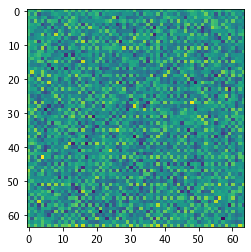

In [20]:
plt.imshow(decoder.predict(np.random.rand(4,32))[0,:,:,40,0])

In [21]:
vae.train_on_batch(TD_subs[0:5,:,:,:])

909.70947265625

In [22]:
pwd

'/Users/aidasaglinskas/Desktop/BC-MRI-AE'

In [ ]:
t0 = now()
print(f'started: {now()}')
loss = list()
for i in range(1):
    e0 = now()
    #hist = vae.fit([DX_subs,TD_subs[0:456,:,:,:]],epochs=1)

    loss.append(hist.history['loss']);loss = loss[0:min((50,len(loss)))]

    cvae.save_weights('../tf_outputs/3D_CCVAE_Weights/Nov23')
    print(f"epoch time: {now()-e0}, elapsed time: {now()-t0}")
    if np.mod(i,25)==0:
        #plot_state_ccvae(latent_dim)
        plot_recon_vae()
        plt.show()
        plt.plot(loss);plt.title('loss')
        plt.show()
print(f'done in: {now()-t0}')

In [ ]:
#plot_state_cvae()

# TRAIN THE CONTRASTIVE VAE

In [ ]:
latent_dim = 16
cvae, cvae_fg, z_encoder, z_encoder, cvae_decoder = get_MRI_CCVAE_3D(latent_dim=latent_dim)
#cvae.load_weights('../tf_outputs/3D_CCVAE_Weights/Nov23')

In [ ]:
def plot_recon():
    plt.figure(figsize=(5,5));
    plt.subplot(2,2,1)
    plt.imshow(DX_batch[0,:,:,40]);plt.xticks([]);plt.yticks([]);plt.title('input');
    plt.subplot(2,2,2)
    plt.imshow(cvae.predict([DX_batch,TD_batch])[0][0,:,:,40,0]);plt.xticks([]);plt.yticks([]);plt.title('reconstruction');

    plt.subplot(2,2,3)
    plt.imshow(TD_batch[0,32,:,:]);plt.xticks([]);plt.yticks([]);
    plt.subplot(2,2,4)
    plt.imshow(cvae.predict([DX_batch,TD_batch])[1][0,32,:,:,0]);plt.xticks([]);plt.yticks([]);

In [ ]:
t0 = now()
print(f'started: {now()}')
loss = list()
for i in range(500):
    e0 = now()
    hist = cvae.fit([DX_subs,TD_subs[0:456,:,:,:]],epochs=1)

    loss.append(hist.history['loss']);loss = loss[0:min((50,len(loss)))]

    cvae.save_weights('../tf_outputs/3D_CCVAE_Weights/Nov23')
    print(f"epoch time: {now()-e0}, elapsed time: {now()-t0}")
    if np.mod(i,25)==0:
        #plot_state_ccvae(latent_dim)
        plot_recon()
        plt.show()
        plt.plot(loss);plt.title('loss')
        plt.show()
print(f'done in: {now()-t0}')

In [ ]:
len(loss)